In [2]:
from io import StringIO 
import sys
import os.path
from os import path
# this is just to help you saev the flicker dataset in your google drive so
# it is in permanent memory and you don't have to redownload it every time you run
# flicker 8k dataset should be in a folder called "alt-text-generation"

In [3]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np

from keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.layers import concatenate
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

# small library for seeing the progress of loops.
from tqdm.notebook import tqdm
tqdm().pandas()

0it [00:00, ?it/s]

In [4]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [5]:
# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [caption]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

In [6]:
##Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    # table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            
            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lower case
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            # desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

In [7]:
def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    
    return vocab

In [8]:
#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [9]:
dataset_text = "Flickr8k_text"
dataset_images = "Flicker8k_Dataset"

In [10]:
#we prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

#saving each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8357


In [11]:
def extract_features(directory):
    model = Xception( include_top=False, pooling='avg' )
    features = {}
    for img in tqdm(os.listdir(directory)):
        filename = directory + "/" + img
        image = Image.open(filename)
        image = image.resize((299,299))
        image = np.expand_dims(image, axis=0)
        #image = preprocess_input(image)
        image = image/127.5
        image = image - 1.0

        feature = model.predict(image)
        features[img] = feature
    return features

In [ ]:
#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("features.p","wb"))

In [12]:
features = load(open("features.p","rb"))

In [13]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


def load_clean_descriptions(filename, photos):   
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        
        words = line.split()
        if len(words)<1 :
            continue
    
        image, image_caption = words[0], words[1:]
        
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = 'startseq ' + " ".join(image_caption) + ' endseq'
            descriptions[image].append(desc)

    return descriptions


def load_features(photos, feature_file="features.p"):
    #loading all features
    all_features = load(open(feature_file,"rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features


In [14]:
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [15]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary 

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer


In [17]:
# give each word a index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size 

7266

In [16]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(descriptions)
max_length

31

In [110]:
features['1000268201_693b08cb0e.jpg'][0]

array([0.47339708, 0.01732647, 0.07333975, ..., 0.08559047, 0.02102302,
       0.23766533], dtype=float32)

In [18]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]         

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [26]:
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((47, 2048), (47, 32), (47, 7577))

In [19]:
from keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):
    
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(512 , activation='relu')(fe1)
    fe3 = Dense(256 , activation = 'relu')(fe2)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 512, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(512, return_sequences=True)(se2)
    se4 = Dropout(0.5)(se3)
    se5 = LSTM(256)(se4)

    # Merging both models
    decoder1 = concatenate([fe3, se5])
    decoder2 = Dense(256, activation='relu')(decoder1)
    decoder3 = Dense(512, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder3)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    
    return model

In [45]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
folder = "models3"
# making a directory models to save our models
if not os.path.exists(folder):
    os.mkdir(folder)
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save(f"{folder}/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 32)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 32, 512)      3879424     ['input_10[0][0]']               
                                                                                                  
 input_9 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dropout_12 (Dropout)           (None, 32, 512)      0           ['embedding_4[0][0]

/var/folders/b4/kmgwdkbj4nn7rv403zgbf13c0000gn/T/ipykernel_54800/1686809828.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)


6000/6000 [==============================] - 2079s 346ms/step - loss: 2.7997


In [46]:
model = load_model('./models3/model_9.h5')

In [21]:
filename = dataset_text + "/" + "Flickr_8k.testImages.txt"

#train = loading_data(filename)
test_imgs = load_photos(filename)
test_descriptions = load_clean_descriptions("descriptions.txt", test_imgs)
test_features = load_features(test_imgs)

In [20]:
def word_for_id(integer , tokenizer):
    for word,index in tokenizer.word_index.items():
        if index == integer:
            return word

In [22]:
tokenizer = load(open('tokenizer.p', 'rb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7266

In [23]:
def generate_desc(model, tokenizer, photo, max_length):
    input_text = 'startseq'
    
    for i in range(max_length):
        
        sequence = tokenizer.texts_to_sequences([input_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        # predict the next word
        next_word_id = model.predict([photo,sequence], verbose = 0)
        
        # get highest probality word from list of words
        next_word_id = np.argmax(next_word_id)
        # we can experiment with sample & beam search here
        
        # get word from id
        word = word_for_id(next_word_id, tokenizer)
        
        if word is None:
            break
            
        # update input text
        input_text += ' '+ word
        
        if word == 'endseq':
            break
            
    return input_text

In [35]:
from nltk.translate.bleu_score import corpus_bleu

In [64]:
def evaluate_model(model, desciptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    
    for key, desc_list in desciptions.items():
        generated_desc = generate_desc(model, tokenizer, photos[key], max_length)
        
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(generated_desc.split())
    bleu_1 = corpus_bleu(actual, predicted, weights=(1,0,0,0))
    bleu_2 = corpus_bleu(actual, predicted, weights=(0.5,0.5,0,0))
    bleu_3 = corpus_bleu(actual, predicted, weights=(0.33,0.33,0.33,0))
    bleu_4 = corpus_bleu(actual, predicted, weights=(0.25,0.25,0.25,0.25))
    print(f'Bleu_Score -1 = {bleu_1}')
    print(f'Bleu_Score -2 = {bleu_2}')
    print(f'Bleu_Score -3 = {bleu_3}')
    print(f'Bleu_Score -4 = {bleu_4}')
    return bleu_1, bleu_2, bleu_3, bleu_4

In [67]:
results = {'bleu_1': [], 'bleu_2': [], 'bleu_3': [], 'bleu_4': []}
for i in range(epochs):
    model = load_model(f'./models2/model_{i}.h5')
    print(f"evaluating model_{i}")
    bleu_1, bleu_2, bleu_3, bleu_4 = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
    results['bleu_1'].append(bleu_1)
    results['bleu_2'].append(bleu_2)
    results['bleu_3'].append(bleu_3)
    results['bleu_4'].append(bleu_4)
dump(results, open("model2_eval.p","wb"))

evaluating model_0
Bleu_Score -1 = 0.17033333333333336
Bleu_Score -2 = 0.08857753195176907
Bleu_Score -3 = 0.04473800754253917
Bleu_Score -4 = 0.019923334054341164
evaluating model_1
Bleu_Score -1 = 0.1694848484848485
Bleu_Score -2 = 0.09280058654791125
Bleu_Score -3 = 0.050559464321408044
Bleu_Score -4 = 0.024395655018808585
evaluating model_2
Bleu_Score -1 = 0.16512121212121209
Bleu_Score -2 = 0.08931639581065762
Bleu_Score -3 = 0.049564971711707415
Bleu_Score -4 = 0.025034692462845613
evaluating model_3
Bleu_Score -1 = 0.1541818181818182
Bleu_Score -2 = 0.08461570883599677
Bleu_Score -3 = 0.04742216645959778
Bleu_Score -4 = 0.02361799865565174
evaluating model_4
Bleu_Score -1 = 0.16642424242424242
Bleu_Score -2 = 0.09139155686750644
Bleu_Score -3 = 0.05166896742235373
Bleu_Score -4 = 0.02702991588414856
evaluating model_5
Bleu_Score -1 = 0.17187878787878788
Bleu_Score -2 = 0.09405523038957676
Bleu_Score -3 = 0.05247169773210867
Bleu_Score -4 = 0.026962570763061387
evaluating model_6

In [68]:
results = {'bleu_1': [], 'bleu_2': [], 'bleu_3': [], 'bleu_4': []}
for i in range(epochs):
    model = load_model(f'./models3/model_{i}.h5')
    print(f"evaluating model_{i}")
    bleu_1, bleu_2, bleu_3, bleu_4 = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
    results['bleu_1'].append(bleu_1)
    results['bleu_2'].append(bleu_2)
    results['bleu_3'].append(bleu_3)
    results['bleu_4'].append(bleu_4)
dump(results, open("model3_eval.p","wb"))

evaluating model_0
Bleu_Score -1 = 0.15233333333333332
Bleu_Score -2 = 0.08125698687907806
Bleu_Score -3 = 0.04331790444889184
Bleu_Score -4 = 0.020156294227635742
evaluating model_1
Bleu_Score -1 = 0.14145454545454544
Bleu_Score -2 = 0.0766759711086501
Bleu_Score -3 = 0.04141081823577351
Bleu_Score -4 = 0.019028786499208583
evaluating model_2
Bleu_Score -1 = 0.15227272727272728
Bleu_Score -2 = 0.08223053444709297
Bleu_Score -3 = 0.043866357581651125
Bleu_Score -4 = 0.02086120616592461
evaluating model_3
Bleu_Score -1 = 0.16515151515151516
Bleu_Score -2 = 0.08778012519236848
Bleu_Score -3 = 0.04664137021399346
Bleu_Score -4 = 0.02170432180024491
evaluating model_4
Bleu_Score -1 = 0.17218181818181819
Bleu_Score -2 = 0.09067349016212964
Bleu_Score -3 = 0.0493625712033774
Bleu_Score -4 = 0.024023144997121843
evaluating model_5
Bleu_Score -1 = 0.17166666666666666
Bleu_Score -2 = 0.09524447709272524
Bleu_Score -3 = 0.052946327762524635
Bleu_Score -4 = 0.0258724441158954
evaluating model_6
B

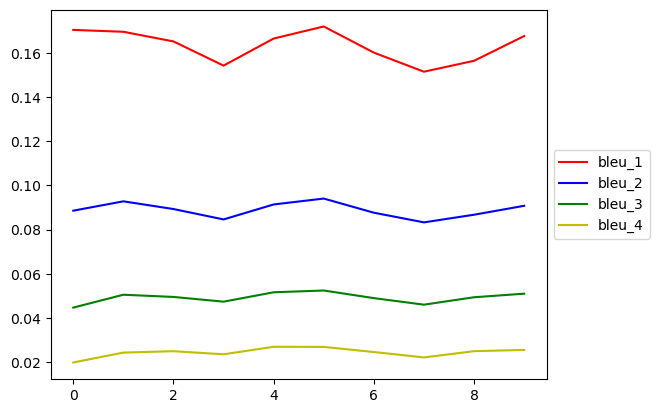

In [70]:
import matplotlib.pyplot as plt
# simple model
results = load(open("model2_eval.p", "rb"))
i = 0
colors = ['r-', 'b-', 'g-', 'y-']
for key in results:
    plt.plot(results[key], colors[i], label=key)
    i += 1
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

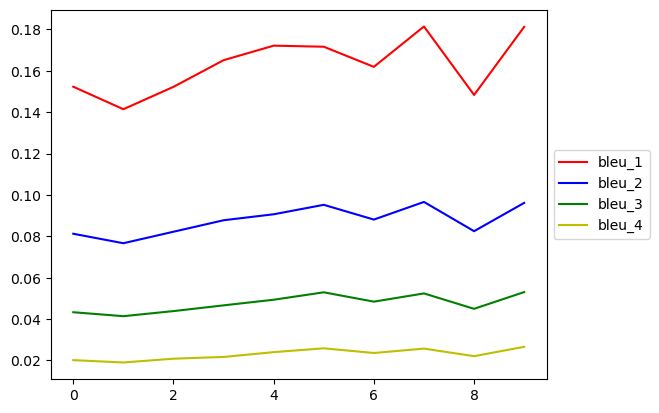

In [71]:
# deeper model
results = load(open("model3_eval.p", "rb"))
i = 0
colors = ['r-', 'b-', 'g-', 'y-']
for key in results:
    plt.plot(results[key], colors[i], label=key)
    i += 1
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

## Use pretrained embedding for caption tokens

In [75]:
path_to_glove_file = "glove/glove.6B.300d.txt"
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
tokenizer.word_index

In [112]:
num_tokens = vocab_size
embedding_dim = 300
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 6767 words (498 misses)


In [116]:
# define the captioning model
def define_model2(vocab_size, max_length):
    
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(512 , activation='relu')(fe1)
    fe3 = Dense(256 , activation = 'relu')(fe2)

    # LSTM sequence model, with pre-trained embedding from Glove dataset
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 300, mask_zero=True, 
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                    trainable=False)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(512, return_sequences=True)(se2)
    se4 = Dropout(0.5)(se3)
    se5 = LSTM(256)(se4)

    # Merging both models
    decoder1 = concatenate([fe3, se5])
    decoder2 = Dense(256, activation='relu')(decoder1)
    decoder3 = Dense(512, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder3)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    print(model.summary())
    
    return model

In [117]:
from tensorflow import keras
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model2(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
folder = "models4"
# making a directory models to save our models
if not os.path.exists(folder):
    os.mkdir(folder)
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save(f"{folder}/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7266
Description Length:  31
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 31)]         0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 31, 300)      2179800     ['input_16[0][0]']               
                                                                                                  
 input_15 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 dropout_19 (Dropout)           (None, 31, 300)      0           ['embedding_6[0][0]

/var/folders/b4/kmgwdkbj4nn7rv403zgbf13c0000gn/T/ipykernel_54800/2670245547.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)


6000/6000 [==============================] - 1582s 264ms/step - loss: 2.8557


In [118]:
results = {'bleu_1': [], 'bleu_2': [], 'bleu_3': [], 'bleu_4': []}
for i in range(epochs):
    model = load_model(f'./models4/model_{i}.h5')
    print(f"evaluating model_{i}")
    bleu_1, bleu_2, bleu_3, bleu_4 = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
    results['bleu_1'].append(bleu_1)
    results['bleu_2'].append(bleu_2)
    results['bleu_3'].append(bleu_3)
    results['bleu_4'].append(bleu_4)
dump(results, open("model4_eval.p","wb"))

evaluating model_0
Bleu_Score -1 = 0.37827342427561483
Bleu_Score -2 = 0.20143387953231112
Bleu_Score -3 = 0.09912413838391419
Bleu_Score -4 = 0.04278916213750296
evaluating model_1
Bleu_Score -1 = 0.32470352430265575
Bleu_Score -2 = 0.17609282656442543
Bleu_Score -3 = 0.09121182418100698
Bleu_Score -4 = 0.041577592505911844
evaluating model_2
Bleu_Score -1 = 0.34514109271807186
Bleu_Score -2 = 0.18244697248371997
Bleu_Score -3 = 0.09311362284461781
Bleu_Score -4 = 0.044202379270988634
evaluating model_3
Bleu_Score -1 = 0.35156885794375625
Bleu_Score -2 = 0.18991866274510308
Bleu_Score -3 = 0.10010840770839884
Bleu_Score -4 = 0.04956912690578213
evaluating model_4
Bleu_Score -1 = 0.3559011893870082
Bleu_Score -2 = 0.1986477978347654
Bleu_Score -3 = 0.11042136224105942
Bleu_Score -4 = 0.05624152242622845
evaluating model_5
Bleu_Score -1 = 0.35676368295808164
Bleu_Score -2 = 0.20268718873187658
Bleu_Score -3 = 0.113950314905327
Bleu_Score -4 = 0.0597664899648889
evaluating model_6
Bleu_S

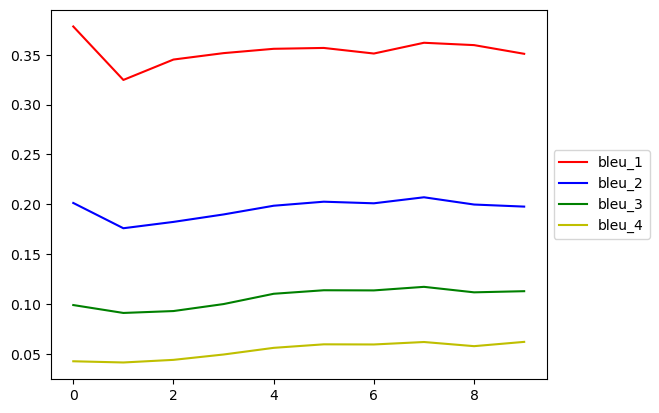

In [119]:
# pre-trained embedding
results = load(open("model4_eval.p", "rb"))
i = 0
colors = ['r-', 'b-', 'g-', 'y-']
for key in results:
    plt.plot(results[key], colors[i], label=key)
    i += 1
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

## Incorporate pre-train imagenet weights

In [120]:
def extract_imgnet_features(directory):
    model = Xception(include_top=False, pooling='avg', weights='imagenet')
    features = {}
    for img in tqdm(os.listdir(directory)):
        filename = directory + "/" + img
        image = Image.open(filename)
        image = image.resize((299,299))
        image = np.expand_dims(image, axis=0)
        #image = preprocess_input(image)
        image = image/127.5
        image = image - 1.0

        feature = model.predict(image)
        features[img] = feature
    return features

In [ ]:
features = extract_features(dataset_images)
dump(features, open("features_imagenet.p","wb"))

In [123]:
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs, "features_imagenet.p")

In [124]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model2(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
folder = "models5"
# making a directory models to save our models
if not os.path.exists(folder):
    os.mkdir(folder)
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save(f"{folder}/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7266
Description Length:  31
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 31)]         0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 31, 300)      2179800     ['input_19[0][0]']               
                                                                                                  
 input_18 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 dropout_22 (Dropout)           (None, 31, 300)      0           ['embedding_7[0][0]

/var/folders/b4/kmgwdkbj4nn7rv403zgbf13c0000gn/T/ipykernel_54800/406890711.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)


6000/6000 [==============================] - 1571s 262ms/step - loss: 2.8582


In [125]:
test_imgs = load_photos(filename)
test_descriptions = load_clean_descriptions("descriptions.txt", test_imgs)
test_features = load_features(test_imgs, "features_imagenet.p")

In [127]:
def evaluate(model, model_id, test_descriptionscriptions, test_features, tokenizer, max_length):
    results = {'bleu_1': [], 'bleu_2': [], 'bleu_3': [], 'bleu_4': []}
    for i in range(epochs):
        model = load_model(f'./models{model_id}/model_{i}.h5')
        print(f"evaluating model_{i}")
        bleu_1, bleu_2, bleu_3, bleu_4 = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
        results['bleu_1'].append(bleu_1)
        results['bleu_2'].append(bleu_2)
        results['bleu_3'].append(bleu_3)
        results['bleu_4'].append(bleu_4)
    dump(results, open(f"model{model_id}_eval.p","wb"))

In [128]:
evaluate(model, 5, test_descriptions, test_features, tokenizer, max_length)

evaluating model_0
Bleu_Score -1 = 0.5521630561681152
Bleu_Score -2 = 0.3051581199971846
Bleu_Score -3 = 0.17873741845278857
Bleu_Score -4 = 0.09746011574903123
evaluating model_1
Bleu_Score -1 = 0.565093200143636
Bleu_Score -2 = 0.3177924324804411
Bleu_Score -3 = 0.19096568284790177
Bleu_Score -4 = 0.10708553085979218
evaluating model_2
Bleu_Score -1 = 0.5639860942573218
Bleu_Score -2 = 0.318557574393628
Bleu_Score -3 = 0.19507469344472478
Bleu_Score -4 = 0.113170807459417
evaluating model_3
Bleu_Score -1 = 0.561759756914381
Bleu_Score -2 = 0.32054855657567527
Bleu_Score -3 = 0.19769002206230396
Bleu_Score -4 = 0.11501375636603751
evaluating model_4
Bleu_Score -1 = 0.5618203522312888
Bleu_Score -2 = 0.31988150757296935
Bleu_Score -3 = 0.19794088648592797
Bleu_Score -4 = 0.11457159947266293
evaluating model_5
Bleu_Score -1 = 0.5570203728466924
Bleu_Score -2 = 0.31605251383821537
Bleu_Score -3 = 0.1937245218366675
Bleu_Score -4 = 0.11263074432825403
evaluating model_6
Bleu_Score -1 = 0.

In [129]:
def plot_bleu(model_id):
    results = load(open(f"model{model_id}_eval.p", "rb"))
    i = 0
    colors = ['r-', 'b-', 'g-', 'y-']
    for key in results:
        plt.plot(results[key], colors[i], label=key)
        i += 1
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

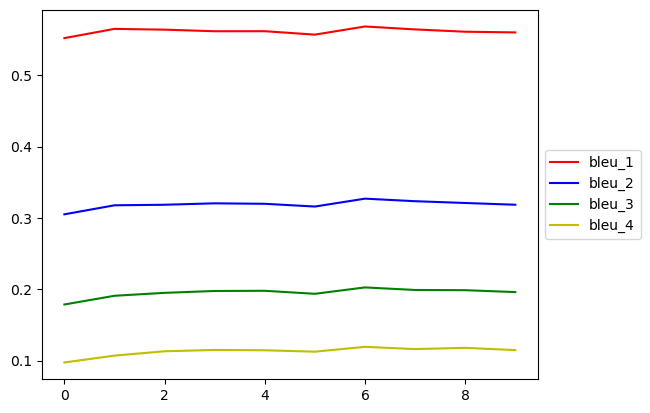

In [130]:
plot_bleu(5)

## Test with specific photos

In [25]:
from IPython.display import Image,display

In [26]:
def extract_features_for_one_image(filename):
    model = Xception(include_top=False, pooling='avg', weights='imagenet')
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    image = load_img(filename, target_size=((299,299)))
    image = img_to_array(image)
    image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
    # image = preprocess_input(image)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image, verbose=0)
    
    return feature

In [30]:
def get_image_caption(filename, model):
    tokenizer = load(open('tokenizer.p','rb'))
    photo = extract_features_for_one_image(filename)
    desc = generate_desc(model, tokenizer, photo, 31)
    desc = desc.replace('startseq','')
    desc = desc.replace('endseq','')
    return desc.title()

In [31]:
model = load_model('models5/model_6.h5')

 Man In Red Shirt Is Walking On The Beach 


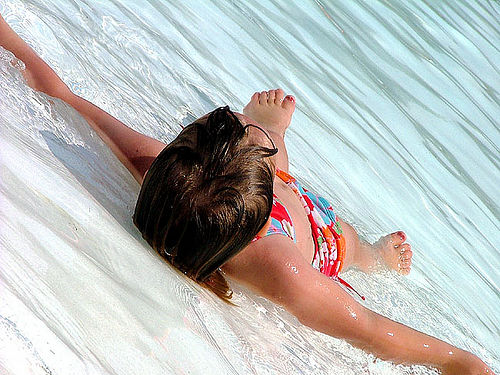

In [32]:
filename = f'{dataset_images}/667626_18933d713e.jpg'
print(get_image_caption(filename, model))
display(Image(filename))

 Two People Are Walking Along The Beach 


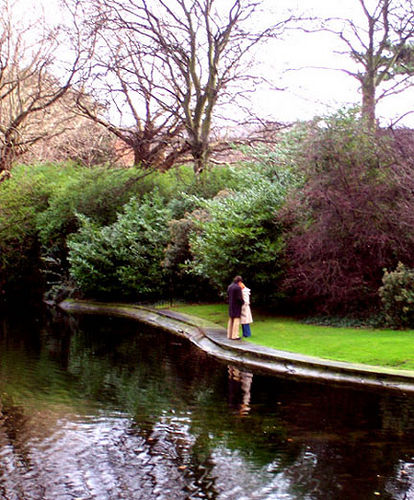

In [33]:
filename = f'{dataset_images}/3637013_c675de7705.jpg'
print(get_image_caption(filename, model))
display(Image(filename))

 Man In Black Shirt Is Sitting On The Grass 


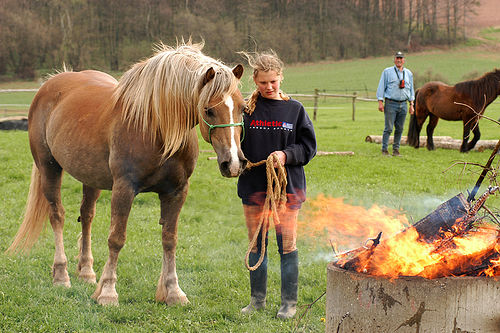

In [34]:
filename = f'{dataset_images}/10815824_2997e03d76.jpg'
print(get_image_caption(filename, model))
display(Image(filename))